In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pubg-games-dataset/PUBG_Game_Prediction_data.csv


<center><font color= "green">PUBG Game Prediction</font></center>

<center><img src  ="https://media.giphy.com/media/zaUTLcbjhWpTrNYoFG/giphy.gif"></center>

<font color ="green">Importing Libraries<a class="anchor" id="import"></a>

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"]=(16,6)
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import catboost as cb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


<font color ="green">Reading Data<a class="anchor" id="import"></a>

In [3]:
df=pd.read_csv('/kaggle/input/pubg-games-dataset/PUBG_Game_Prediction_data.csv')

In [4]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [6]:
df.shape

(4446966, 29)

In [7]:
df.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

<font color ="green">Data Wrangling <a class="anchor" id="import"></a>

**Check for the rows with missing win prediciton value**

In [8]:
df[df['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [9]:
df.drop(2744604,inplace=True)

**Understanding Player Distribution in game**

In [10]:
# Prepare new parameter to count how many new players are in game
df['PlayersJoined']=df.groupby('matchId')['matchId'].transform('count')    

In [11]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,PlayersJoined
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0.0000,0,0.00,0,0,244.80,1,1466,0.4444,96
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0.0045,0,11.04,0,0,1434.00,5,0,0.6400,91
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0.0000,0,0.00,0,0,161.80,2,0,0.7755,98
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0.0000,0,0.00,0,0,202.70,3,0,0.1667,91
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0.0000,0,0.00,0,0,49.75,2,0,0.1875,97


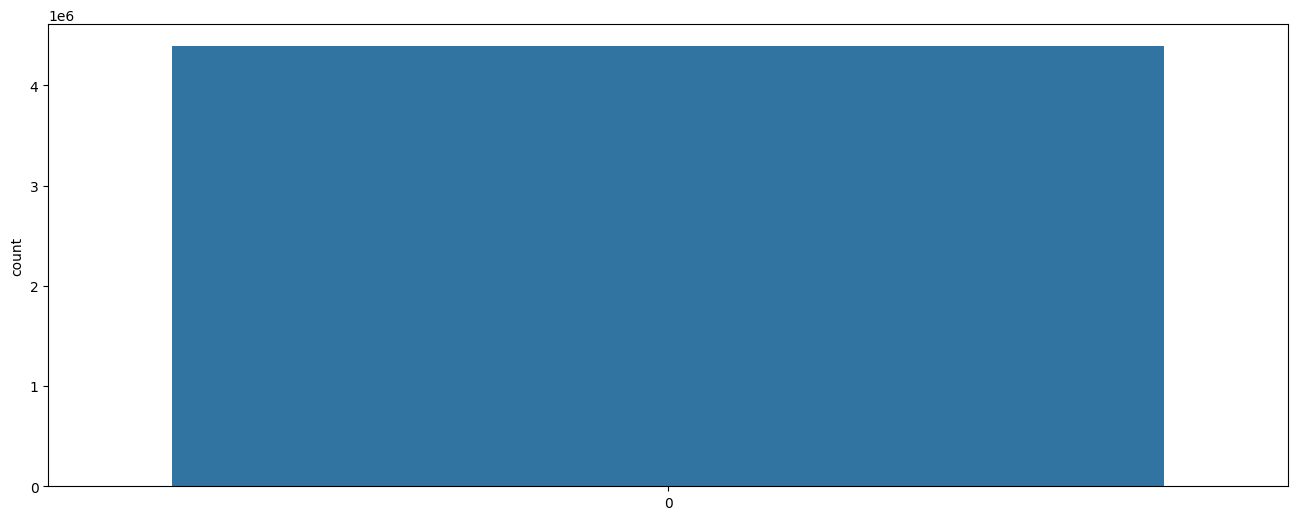

In [12]:
sns.countplot(df[df['PlayersJoined']>=75]['PlayersJoined'])
plt.show()

<font color ="green">Analysing data<a class="anchor" id="import"></a>

**Kills Without Moving ?**

<center><img src  ="https://i.gifer.com/g1OF.gif"></center>

In [13]:
#prepare new data parameter to gather the total distance travelled
df['totalDistance']=df['rideDistance'] +df['swimDistance']+df['walkDistance'] 

#Preparing the data parameter to check for anmoly detection 
# that the person has not moved but still manages to do the kills

df['KillsWithoutMoving']=((df['kills']>0) & (df['totalDistance']==0))

In [14]:
# Here we can see that there are
df[df['KillsWithoutMoving']==True].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,PlayersJoined,totalDistance,KillsWithoutMoving
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.0,0,0,3,18,...,0.0,0,0,0.0,8,0,0.8571,58,0.0,True
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.6,0,0,6,33,...,0.0,0,0,0.0,22,0,0.6000,42,0.0,True
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.0,0,4,5,3,...,0.0,0,0,0.0,13,0,0.8947,21,0.0,True
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.8,0,0,0,69,...,0.0,0,0,0.0,7,1500,0.0000,73,0.0,True
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.0,0,1,0,37,...,0.0,0,0,0.0,10,0,0.3000,42,0.0,True


In [15]:
df[df['KillsWithoutMoving']==True].index

Index([   1824,    6673,   11892,   14631,   15591,   20881,   23298,   24640,
         25659,   30079,
       ...
       4426500, 4429697, 4432954, 4436511, 4437516, 4440232, 4440898, 4440927,
       4441511, 4446682],
      dtype='int64', length=1535)

In [16]:
# here 
df[df['KillsWithoutMoving']==True].shape

(1535, 32)

In [17]:
#drop the table
df.drop(df[df['KillsWithoutMoving']==True].index,inplace=True)

**EXTRA ORDINARY ROAD KILLS ??**

<center><img src  ="https://media.giphy.com/media/rhaeywi71wkcXRTZK6/giphy.gif"></center>

In [18]:
df[df['roadKills']>5].head()


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,PlayersJoined,totalDistance,KillsWithoutMoving
39338,0097d2ae7a8576,b61edfa0c228d4,a786011fe206e9,1,2,495.7,4,0,0,2,...,0.0,0,0,72.80,1,0,0.9362,92,5202.80,False
90312,0e6ea81fd1b9b3,1e96ac916d6fbb,3f150f3834422c,2,6,190.0,0,0,5,2,...,0.0,0,1,976.80,4,0,0.9556,89,4257.80,False
197752,6cf1efa197bcc1,28df010b29a9e2,2e40495266529f,0,2,800.0,5,0,4,1,...,0.0,0,0,1516.00,3,0,0.6538,89,10085.00,False
209676,5df28fce2b8128,32a01a5517635a,ee9fb50eb0fe00,0,3,360.0,2,0,4,1,...,0.0,0,0,36.96,0,0,1.0000,59,6142.96,False
213544,612ee3024560a3,ab0162b0300c59,7c5535bfd43592,1,2,426.3,3,0,0,1,...,0.0,0,0,128.30,3,0,0.9167,96,3607.30,False


In [19]:
print(df[df['roadKills']>5].shape)

(46, 32)


In [20]:
#Dropping the Extraordinary road kills
df.drop(df[df['roadKills']>5].index,inplace=True)

In [21]:
# cleared all the extraordinary road kills
print(df[df['roadKills']>5].shape)

(0, 32)


## SO Many KILLS -HOW ??

In [22]:
df[df['kills']>20].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,PlayersJoined,totalDistance,KillsWithoutMoving
2569,7711e1d39407da,a9fbc63469296f,45fc89f9b11eaf,1,4,2325.0,13,8,2,1,...,0.0,0,0,2697.0,5,1505,1.0000,97,4709.0,False
19531,ef706f0f248dbf,f27e63bfc6746c,7d2fd7f5d4f8b2,9,0,2856.0,32,3,0,1,...,0.0,0,0,1136.0,20,0,0.8000,40,1136.0,False
37505,44513e16340a63,c1e3f56e09b9a4,cf5dd782577ea9,1,2,2767.0,24,17,1,1,...,0.0,0,0,3290.0,7,1509,0.9615,97,5879.0,False
40047,8d8d78ba4e9b55,6634da8e3940de,8a728def0644be,3,0,1988.0,22,6,5,5,...,0.0,0,0,1864.0,33,1500,1.0000,54,3532.0,False
53442,f7a740ffbc2c43,418f6120b2e193,f2614050e9046a,2,0,1906.0,0,4,19,2,...,0.0,0,0,116.7,16,0,1.0000,11,116.7,False


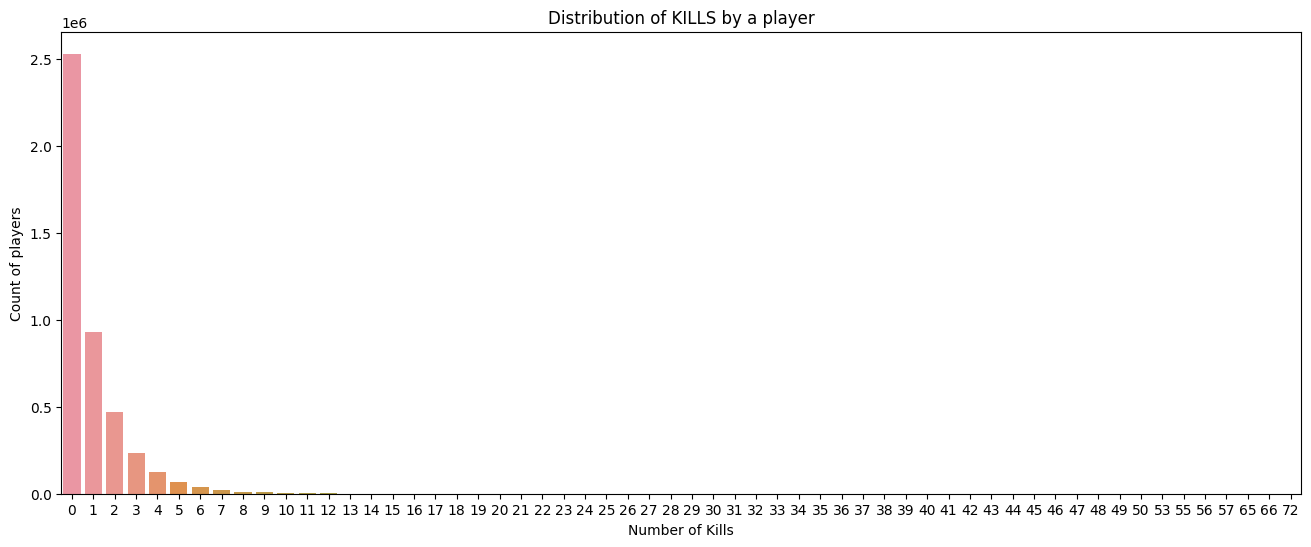

In [23]:
sns.countplot(data=df,x=df['kills']).set_title("Distribution of KILLS by a player")
plt.xlabel("Number of Kills")
plt.ylabel("Count of players")
plt.show()

In [24]:
df[df['kills']>15].shape

(1318, 32)

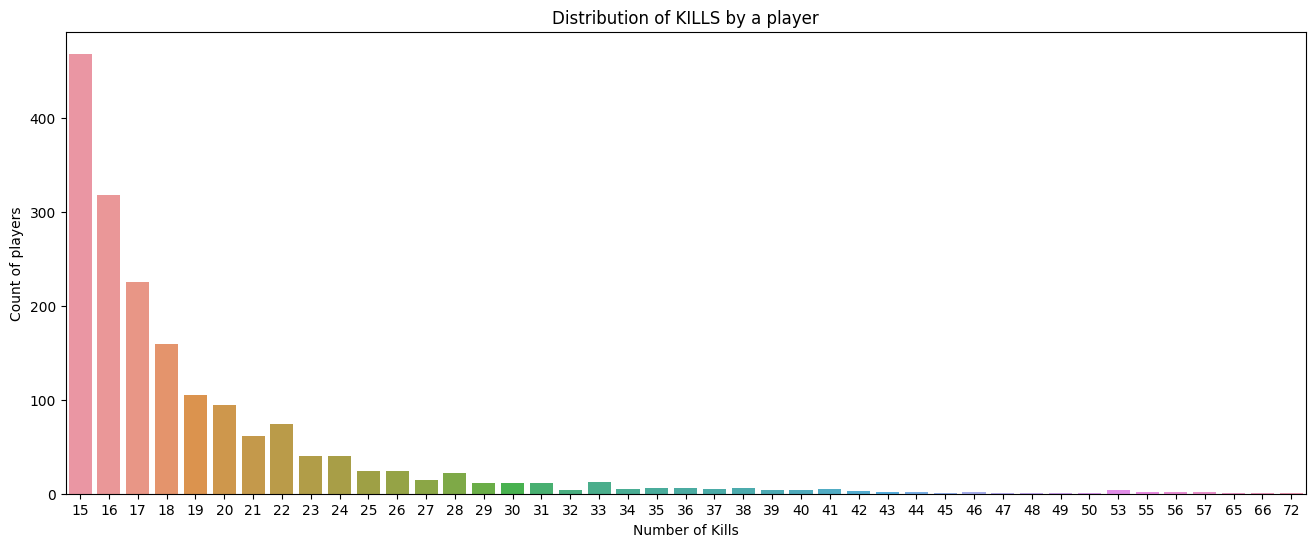

In [25]:
# Upto 15 kills can ne normal 
sns.countplot(x=df[df['kills']>=15]["kills"]).set_title("Distribution of KILLS by a player")
plt.xlabel("Number of Kills")
plt.ylabel("Count of players")
plt.show()

## Removing Kills greater than 20 from dataset

In [26]:
df[df['kills']>20].shape

(417, 32)

In [27]:
# Dropping all 417 vlaues from given dataset
df.drop(df[df['kills']>20].index,inplace =True)

In [28]:
df[df['kills']>20].shape

(0, 32)

## HeadShot

<center><img src  ="https://media.giphy.com/media/Y0mmEpprOh5R9GZA0J/giphy.gif"></center>


In [29]:
df['Headshot_rate']=df['headshotKills']/df['kills']
df['Headshot_rate']=df['Headshot_rate'].fillna(0)

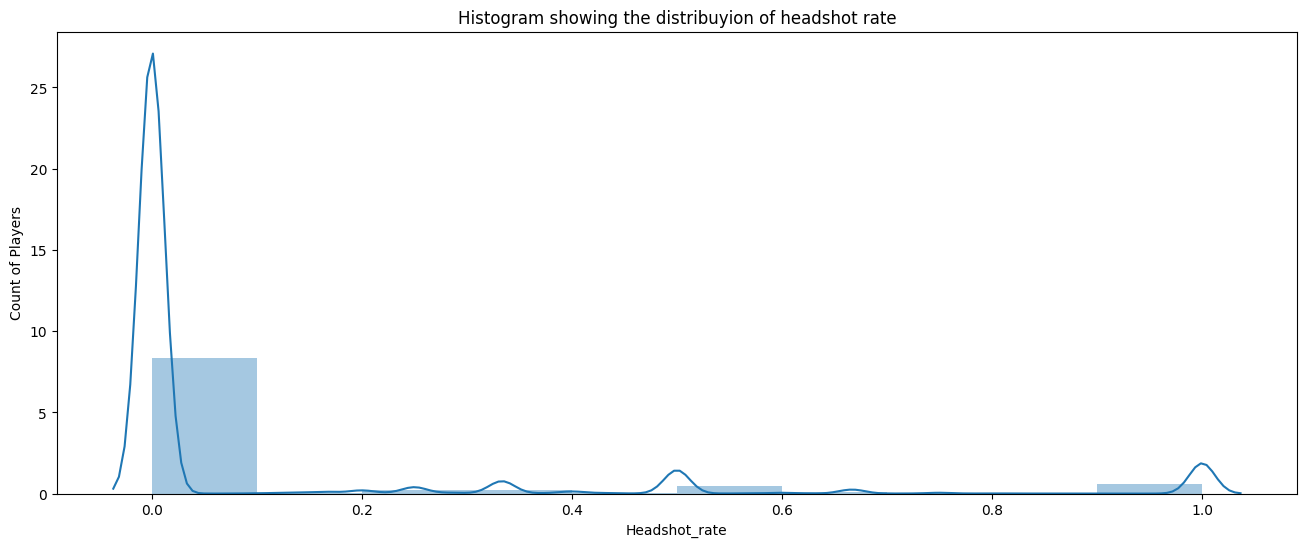

In [30]:
sns.distplot(df['Headshot_rate'],bins=10).set_title("Histogram showing the distribuyion of headshot rate")
plt.ylabel("Count of Players")
plt.show()

In [31]:
df[(df['Headshot_rate']==1)& (df['kills']>5)].shape

(187, 33)

In [32]:
df.drop(df[(df['Headshot_rate']==1)& (df['kills']>6)].index,inplace=True)

## Longest Shot

<center><img src  ="https://tenor.com/bluCZ.gif"></center>

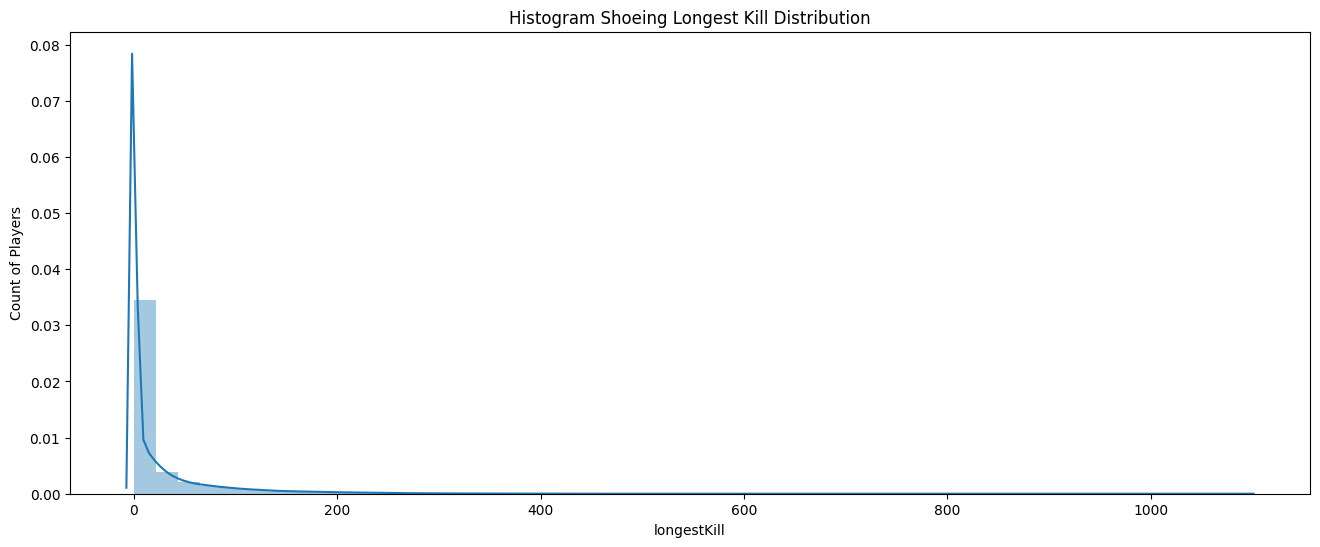

In [33]:
sns.distplot(df['longestKill'],bins=50).set_title("Histogram Shoeing Longest Kill Distribution")
plt.ylabel('Count of Players')
plt.show()

In [34]:
df[df['longestKill']>500].shape

(1745, 33)

In [35]:
df.drop(df[df['longestKill']>500].index,inplace=True)

In [36]:
df[df['longestKill']>500].shape

(0, 33)

## Weapon Change

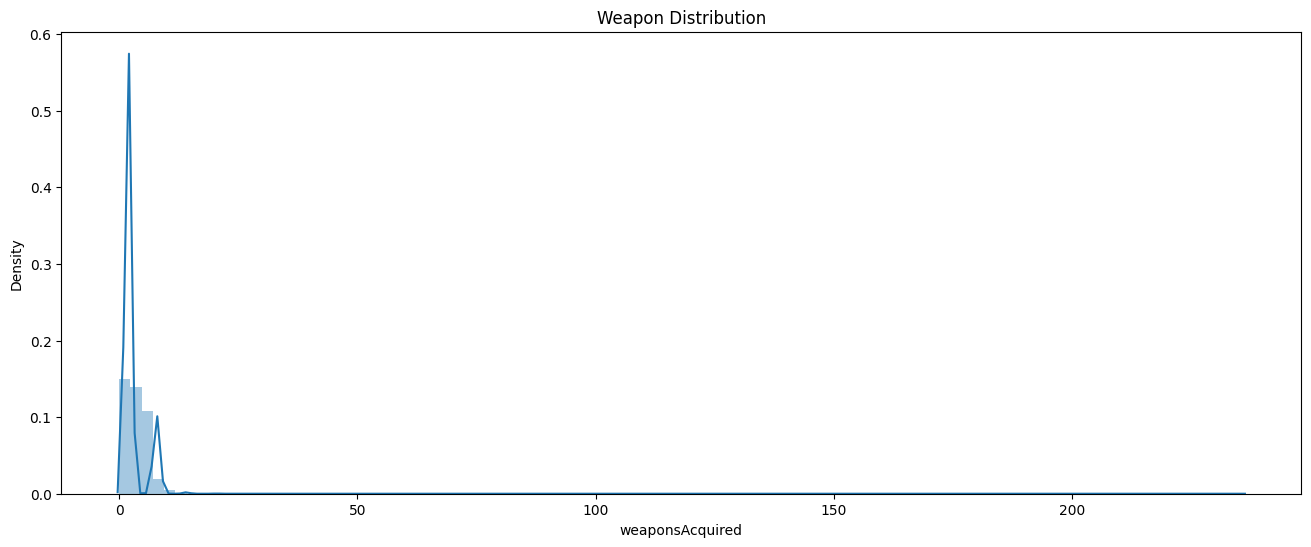

In [37]:
sns.distplot(df['weaponsAcquired'],bins=100).set_title("Weapon Distribution")
plt.show()

In [38]:
# Dropping the weapons changed more than 50 times
df[df['weaponsAcquired']>15].shape

(5435, 33)

In [39]:
df.drop(df[df['weaponsAcquired']>15].index,inplace=True)

In [40]:
df[df['weaponsAcquired']>15].shape

(0, 33)

## EDA


In [41]:
df.shape

(4437682, 33)

In [42]:
df.isnull().sum()

Id                    0
groupId               0
matchId               0
assists               0
boosts                0
damageDealt           0
DBNOs                 0
headshotKills         0
heals                 0
killPlace             0
killPoints            0
kills                 0
killStreaks           0
longestKill           0
matchDuration         0
matchType             0
maxPlace              0
numGroups             0
rankPoints            0
revives               0
rideDistance          0
roadKills             0
swimDistance          0
teamKills             0
vehicleDestroys       0
walkDistance          0
weaponsAcquired       0
winPoints             0
winPlacePerc          0
PlayersJoined         0
totalDistance         0
KillsWithoutMoving    0
Headshot_rate         0
dtype: int64

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4437682 entries, 0 to 4446965
Data columns (total 33 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  object 
 1   groupId             object 
 2   matchId             object 
 3   assists             int64  
 4   boosts              int64  
 5   damageDealt         float64
 6   DBNOs               int64  
 7   headshotKills       int64  
 8   heals               int64  
 9   killPlace           int64  
 10  killPoints          int64  
 11  kills               int64  
 12  killStreaks         int64  
 13  longestKill         float64
 14  matchDuration       int64  
 15  matchType           object 
 16  maxPlace            int64  
 17  numGroups           int64  
 18  rankPoints          int64  
 19  revives             int64  
 20  rideDistance        float64
 21  roadKills           int64  
 22  swimDistance        float64
 23  teamKills           int64  
 24  vehicleDestroys     int64  
 

In [44]:
###sns.heatmap(df.corr(),annot=True)
#pplt.show()

## Feature Engineering

In [45]:
normalising_factor=(100 - df['PlayersJoined']/100)+1

In [46]:
normalising_factor

0          100.04
1          100.09
2          100.02
3          100.09
4          100.03
            ...  
4446961    100.06
4446962    100.07
4446963    100.02
4446964    100.06
4446965    100.02
Name: PlayersJoined, Length: 4437682, dtype: float64

In [47]:
df['killsNorm']=df['kills'] * normalising_factor
df['damageDealtNorm']=df['damageDealt'] * normalising_factor
df['maxPlaceNorm']=df['maxPlace']* normalising_factor
df['matchDurationNorm']=df['matchDuration']* normalising_factor

df['travelDistance']=df['rideDistance'] +df['swimDistance']+df['walkDistance'] 
df['healsnboost']=df['heals'] + df['boosts']
df['assist']=df['assists'] + df['revives']


In [48]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'PlayersJoined',
       'totalDistance', 'KillsWithoutMoving', 'Headshot_rate', 'killsNorm',
       'damageDealtNorm', 'maxPlaceNorm', 'matchDurationNorm',
       'travelDistance', 'healsnboost', 'assist'],
      dtype='object')

In [49]:
data=df.drop(columns=['Id','groupId','matchId','assists','boosts','walkDistance','swimDistance','rideDistance','heals','revives','kills','damageDealt','matchDuration','maxPlace'])

In [50]:
data.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,matchType,numGroups,rankPoints,roadKills,...,totalDistance,KillsWithoutMoving,Headshot_rate,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,travelDistance,healsnboost,assist
0,0,0,60,1241,0,0.00,squad-fpp,26,-1,0,...,244.8000,False,0.0,0.00,0.0000,2801.12,130652.24,244.8000,0,0
1,0,0,57,0,0,0.00,squad-fpp,25,1484,0,...,1445.0445,False,0.0,0.00,9155.2323,2602.34,177859.93,1445.0445,0,0
2,0,0,47,0,0,0.00,duo,47,1491,0,...,161.8000,False,0.0,0.00,6801.3600,5001.00,131826.36,161.8000,0,1
3,0,0,75,0,0,0.00,squad-fpp,30,1408,0,...,202.7000,False,0.0,0.00,3292.9610,3102.79,143729.24,202.7000,0,0
4,0,0,45,0,1,58.53,solo-fpp,95,1560,0,...,49.7500,False,0.0,100.03,10003.0000,9702.91,142442.72,49.7500,0,0


<center><font color= "green">ML - Catboost Model</font></center>

## Handling Categorical Values

In [51]:
x=data.drop(['winPlacePerc'],axis=1)
y=data['winPlacePerc']

In [52]:
features=x.columns

In [53]:
x=pd.get_dummies(x,columns=['matchType','KillsWithoutMoving'])

In [54]:
x.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,numGroups,rankPoints,roadKills,teamKills,...,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp,KillsWithoutMoving_False
0,0,0,60,1241,0,0.00,26,-1,0,0,...,False,False,False,False,False,False,False,False,True,True
1,0,0,57,0,0,0.00,25,1484,0,0,...,False,False,False,False,False,False,False,False,True,True
2,0,0,47,0,0,0.00,47,1491,0,0,...,False,False,False,False,False,False,False,False,False,True
3,0,0,75,0,0,0.00,30,1408,0,0,...,False,False,False,False,False,False,False,False,True,True
4,0,0,45,0,1,58.53,95,1560,0,0,...,False,False,False,False,False,False,True,False,False,True


In [55]:
x.shape

(4437682, 40)

In [56]:
features=x.columns

## Scaling The data

In [57]:
sc=StandardScaler()
sc.fit(x)
x=pd.DataFrame(sc.transform(x))

In [58]:
x.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.582712,-0.383999,0.449564,1.172537,-0.765156,-0.459684,-0.732763,-1.212394,-0.049576,-0.142531,...,-0.033643,-0.005516,-0.013898,-0.008425,-0.054801,-0.206548,-0.370783,-0.405077,1.236300,0.0
1,-0.582712,-0.383999,0.340274,-0.804724,-0.765156,-0.459684,-0.775734,0.803562,-0.049576,-0.142531,...,-0.033643,-0.005516,-0.013898,-0.008425,-0.054801,-0.206548,-0.370783,-0.405077,1.236300,0.0
2,-0.582712,-0.383999,-0.024027,-0.804724,-0.765156,-0.459684,0.169630,0.813065,-0.049576,-0.142531,...,-0.033643,-0.005516,-0.013898,-0.008425,-0.054801,-0.206548,-0.370783,-0.405077,-0.808865,0.0
3,-0.582712,-0.383999,0.996015,-0.804724,-0.765156,-0.459684,-0.560878,0.700389,-0.049576,-0.142531,...,-0.033643,-0.005516,-0.013898,-0.008425,-0.054801,-0.206548,-0.370783,-0.405077,1.236300,0.0
4,-0.582712,-0.383999,-0.096888,-0.804724,0.647425,0.727044,2.232242,0.906736,-0.049576,-0.142531,...,-0.033643,-0.005516,-0.013898,-0.008425,-0.054801,-0.206548,2.696994,-0.405077,-0.808865,0.0


## Splitting Data

In [59]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.3,random_state=0)

In [60]:
print(xtrain.shape, ytrain.shape)
print(xtest.shape, ytest.shape)

(3106377, 40) (3106377,)
(1331305, 40) (1331305,)


##  CatBOOST MODEL

In [61]:
import catboost as cb

In [62]:
train_dataset=cb.Pool(xtrain,ytrain)
test_dataset=cb.Pool(xtest,ytest)

In [63]:
model=cb.CatBoostRegressor(loss_function='RMSE')

## GRID SEARCH

In [64]:
grid={'iterations':[100, 150],
      'learning_rate':[0.03,0.1],
      'depth':[2 ,4, 6, 8]}

model.grid_search(grid, train_dataset)

0:	learn: 0.5483099	test: 0.5486894	best: 0.5486894 (0)	total: 331ms	remaining: 32.8s
1:	learn: 0.5334608	test: 0.5338377	best: 0.5338377 (1)	total: 548ms	remaining: 26.8s
2:	learn: 0.5190872	test: 0.5194634	best: 0.5194634 (2)	total: 766ms	remaining: 24.8s
3:	learn: 0.5051893	test: 0.5055628	best: 0.5055628 (3)	total: 978ms	remaining: 23.5s
4:	learn: 0.4917086	test: 0.4920781	best: 0.4920781 (4)	total: 1.2s	remaining: 22.7s
5:	learn: 0.4786880	test: 0.4790498	best: 0.4790498 (5)	total: 1.4s	remaining: 22s
6:	learn: 0.4660979	test: 0.4664545	best: 0.4664545 (6)	total: 1.67s	remaining: 22.2s
7:	learn: 0.4539261	test: 0.4542794	best: 0.4542794 (7)	total: 1.97s	remaining: 22.6s
8:	learn: 0.4421267	test: 0.4424768	best: 0.4424768 (8)	total: 2.27s	remaining: 22.9s
9:	learn: 0.4307003	test: 0.4310468	best: 0.4310468 (9)	total: 2.56s	remaining: 23.1s
10:	learn: 0.4196603	test: 0.4200031	best: 0.4200031 (10)	total: 2.89s	remaining: 23.4s
11:	learn: 0.4089773	test: 0.4093146	best: 0.4093146 (11

{'params': {'depth': 8, 'iterations': 150, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

In [65]:
feature_importance_df=pd.DataFrame()
feature_importance_df['features']=features
feature_importance_df['importance']=model.feature_importances_

feature_importance_df=feature_importance_df.sort_values(by=['importance'],ascending=False)

In [66]:
feature_importance_df

,features,importance
2,killPlace,40.989540
14,totalDistance,14.135225
20,travelDistance,10.442443
16,killsNorm,9.675370
4,killStreaks,6.892138
19,matchDurationNorm,5.365726
13,PlayersJoined,4.459535
6,numGroups,2.115840
21,healsnboost,1.791765
0,DBNOs,1.040025


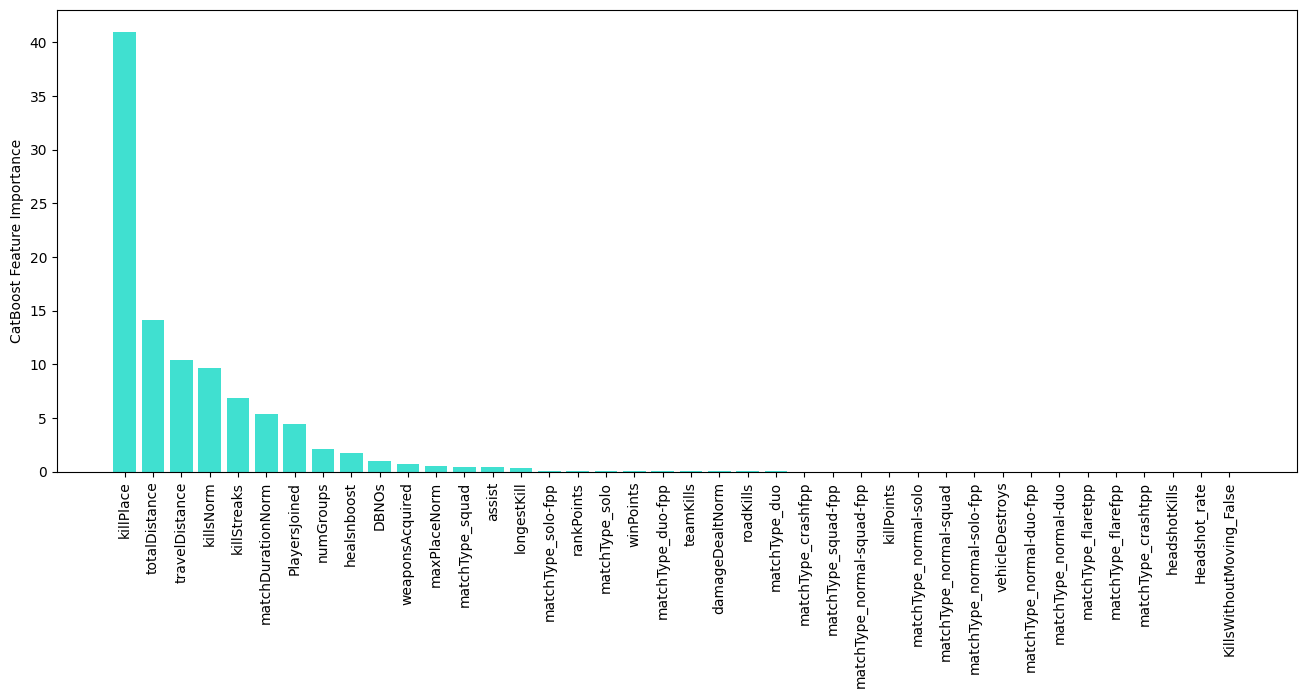

In [67]:
plt.bar(feature_importance_df.features,feature_importance_df.importance,color='turquoise')
plt.ylabel("CatBoost Feature Importance")
plt.xticks(rotation=90)
plt.show()

In [68]:
pred=model.predict(xtest)


In [69]:
rmse=np.sqrt(mean_squared_error(ytest,pred))
r2=r2_score(ytest,pred)

print("TEsting Performance")

print("RMSE: {:.2f}".format(rmse))
print("R2{:.2f}".format(r2))

TEsting Performance
RMSE: 0.08
R20.93


# Rmse is 0.08 which says that our model prediction is only 8 % wrong  whhich is good
# R2 is 0.93 very much close to 1 
# Model performance is good and it is not overfirring

<center><img src  ="https://media.giphy.com/media/KB89dMAtH79VIvxNCW/giphy.gif"></center>